In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from pandas.plotting import bootstrap_plot
import numpy as np
import pandas as pd
import bcolz
import threading

import os
import sys
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset = pd.read_csv('dataset/target.csv')

In [3]:
dataset.describe()

,id,linear,angular
count,4418.000000,4418.000000,4418.000000
mean,2728.039158,0.142612,0.040491
std,1545.866026,0.041647,0.486757
min,80.000000,0.000000,-1.000000
25%,1480.250000,0.120163,-0.347032
50%,2758.500000,0.145027,0.000000
75%,4115.750000,0.161604,0.452466
max,5400.000000,0.281798,1.000000


indices de imagenes que no sirven:
  - 0 - 80
  - 410 - 470
  - 750 - 770
  - 1070 - 1080
  - 1130 - 1243
  - 1272 - 1385
  - 2135 - 2196
  - 2467 - 2580
  - 3030 - 3115
  - 3592 - 3760
  - 4835 - 4928
  - 5131 - 5177
  - 5324 - 5365
  - 5401 - fin

In [9]:
dataset.head()

,id,linear,angular,target
0,80,0.149171,0.0,"[0.14917126297950745, -0.0]"
1,81,0.132595,0.0,"[0.13259488344192505, -0.0]"
2,82,0.124307,0.0,"[0.12430670857429504, -0.0]"
3,83,0.087010,0.0,"[0.08700987696647644, -0.0]"
4,84,0.078722,0.0,"[0.07872170209884644, -0.0]"


In [10]:
def file_path_from_db_id(db_id, pattern="%d.bmp", top="dataset/"):
    """Return file path /top/yyy/xx/blah_zzzxxyyy.png for db_id zzzxxyyy.
    
      The idea is to hash into 1k top level dirs, 000 - 999, then 100
      second level dirs, 00-99, so that the following database ids
      result in the associated file paths:
    
      1234567     /tmp/path/to/imgs/567/34/blah_1234567.png
          432     /tmp/path/to/imgs/432/00/blah_432.png
        29847     /tmp/path/to/imgs/847/29/blah_29847.png
         1432     /tmp/path/to/imgs/432/01/blah_1432.png
      Notice that changing pattern to pattern="blah_%09d.png" and
      top="" would result in:
      1234567     567/34/blah_001234567.png
          432     432/00/blah_000000432.png
        29847     847/29/blah_000029847.png
         1432     432/01/blah_000001432.png
      In general, this will give a decent spread for up to 100 million images.
      If you have more than 10 million images, or your database ids are
      higher, then this function is easily modified.
    """
    s = '%09d' % db_id
    return os.path.join(top, pattern % db_id)

In [11]:
dataset['imgpath'] = dataset.id.apply(file_path_from_db_id)

In [12]:
from sklearn.model_selection import train_test_split

In [41]:
train, test = train_test_split(dataset, test_size=0.2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f8c8bc190>]],
      dtype=object)

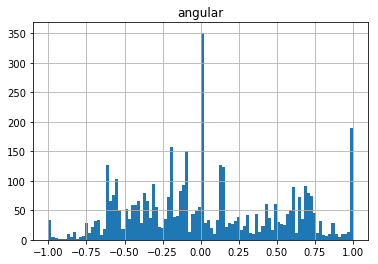

In [42]:
# histograma de los datos
dataset.hist(column='angular', bins=100)

In [39]:
# podemos ver un pico cerca a 0

dataset['angular'].value_counts().max()
#dataset['angular'].value_counts().idxmax()

#removemos los ceros y analizamos de nuevo
nozeros = dataset[dataset.angular != 0.0]
#nozeros.hist(column='angular', bins=50)
#nozeros['angular'].mode()
nozeros.describe()

,id,linear,angular
count,4087.000000,4087.000000,4087.000000
mean,2736.808662,0.144128,0.043770
std,1538.058221,0.041184,0.505947
min,89.000000,0.000000,-1.000000
25%,1502.500000,0.120163,-0.362549
50%,2733.000000,0.145027,-0.047855
75%,4126.500000,0.161604,0.499111
max,5398.000000,0.281798,1.000000


In [43]:
def generator_from_df(df, batch_size, target_size, target_column='target', features=None,
                      debug_merged=False):

    nbatches, n_skipped_per_epoch = divmod(df.shape[0], batch_size)
    count = 1
    epoch = 0

    # New epoch.
    while 1:
        epoch += 1
        i, j = 0, batch_size

        # Mini-batches within epoch.
        mini_batches_completed = 0
        for _ in range(nbatches):

            sub = df.iloc[i:j]

            try:

                X = np.array([

                        (2 *           
                         (img_to_array(load_img(f, target_size=target_size))

                          / 255.0 - 0.5))

                        for f in sub.imgpath])

                Y = sub[target_column].values

                # Simple model, one input, one output.
                mini_batches_completed += 1
                yield X, Y

            except IOError as err:
                count -= 1    
            i = j
            j += batch_size
            count += 1

In [8]:
def extract(target):
    return np.array([float(x) for x in (target.replace("[","").replace("]","").split(","))])

In [9]:
train['target'] = train['target'].apply(extract)
test['target'] = test['target'].apply(extract)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [44]:

nbatches = test.shape[0] / float(32)
for i, (X, Y) in enumerate(generator_from_df(test, 32, (224,224), 'angular')):
        if i == 0:
            print('X: ',X.shape)
            print('Y: ',Y.shape)
            
            print('============================')
            # Keras automatically breaks out of the infinite "while 1"
            # loop in the generator_from_df().  For this test, we need
            # to break manually.
        if i >= 10:
            break
        i += 1

('X: ', (32, 224, 224, 3))
('Y: ', (32,))


In [52]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [50]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')

In [62]:
img = load_img(dataset['imgpath'][0])
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='dataset/extra', save_prefix='', save_format='bmp'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [21]:
score = model.evaluate_generator(generator_from_df(test, 32, (224,224), 'angular'), steps=7)

In [22]:
print(score)

[0.13429456523486547, 0.5401785714285714]


In [23]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
